In [1]:
# Import all the libraries
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, Input, Conv2D, Flatten, BatchNormalization, Reshape
from keras.models import Model,Sequential
from keras.datasets import fashion_mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam as adam

In [2]:
#loading tthe dataset
(x_train,y_train), (x_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [3]:
# normalizing the images
x_train = (x_train.astype(np.float32) - 127.5)/127.5

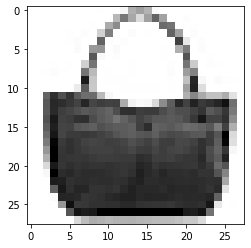

In [4]:
plt.imshow(x_train[100], cmap='Greys')

In [5]:
x_train.shape
#60k samples :)

(60000, 28, 28)

# Basis of GANs
GAN contains 2 Neural Networks, one is Generator and the other is Discriminator. The generator, generates new data instaces , while the other, the discriminator decides whether each instance of data that it reviews belongs to the actual traning dataset or not. In other words theres a theif(generator) and a police(discriminator). The theif is trying to fool the police. Eventually both will get better in the <b>FUTURE :)</b>

In [6]:
#Building the generator nn(THEIF)
def create_generator():
    generator=Sequential()
    generator.add(Conv2D(64, (3,3), strides =(3,3), padding ='same', input_shape = [28,28,1]))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))
    
    generator.add(Conv2D(32, (3,3), strides =(3,3), padding ='same'))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))
  
    
    generator.add(Flatten())
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=28*28, activation='tanh'))
    #generator.add(Reshape((28,28)))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam())
    return generator

In [7]:
g=create_generator()
g.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 10, 10, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 10, 10, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 10, 10, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 32)          18464     
                                                                 
 batch_normalization_1 (Batc  (None, 4, 4, 32)         128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 4, 4, 32)          0

In [8]:
#Creating the discriminator(POLICE|)
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=512,input_dim=28*28))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam())
    return discriminator


In [9]:
d =create_discriminator()
d.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 512)               401920    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)              

In [10]:
#now we have the theif and the police. now we unify both of them to create our GAN

In [11]:
#Creating our GAN 
def create_gan(discriminator, generator):
     discriminator.trainable=False
     img_shape=(28, 28, 1)
     gan_input = Input(img_shape)
     x = generator(gan_input)
     gan_output= discriminator(x)
     gan= Model(inputs=gan_input, outputs=gan_output)
     gan.compile(loss='binary_crossentropy',    optimizer=adam())
     return gan

In [12]:
# We complete the GAN by unifying Generator with the Discriminator
generator= create_generator()
discriminator= create_discriminator()
gan = create_gan(discriminator, generator)

batch_size = 128
Epochs = 300
for epcs in range(1, Epochs):
        print("Epoch Number %d" %epcs)
        for _ in tqdm(range(batch_size)):
        #generate  random noise of shape 28*28 to initialize the generator
            noise= np.random.normal(0,1, [batch_size, 28,28,1])
       
            # Now predict the noise by feeding it to generator
            generated_images = generator.predict(noise)
            
            # Take real images from the Fashion MNIST and reshape it for the discriminator
            image_batch =x_train[np.random.randint(low=0,high=x_train.shape[0],size=128)]
            # The discriminator accepts vector of dimension 784, and hence we reshape the images
            image_batch = image_batch.reshape(-1,28*28)
           
            #We concate both real and fake images to train the discriminator
            X= np.concatenate([image_batch, generated_images])
           
            # We Next assign label to X
            y_discriminator=np.zeros(2*batch_size)
            
            # First  images are true, so we label them 1
            y_discriminator[:batch_size]=1
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_discriminator)
            
            # We trick the noises to be real, so that the GAN eventually learns
            noise= np.random.normal(0,1, [batch_size, 28,28,1])
            y_label = np.ones(batch_size)
            
            # While traininig the GAN, we dont want to alter the weights of the discriminator
            discriminator.trainable=False
         
            # Let us train the GAN  
            gan.train_on_batch(noise, y_label)
            
               

Epoch Number 1


100%|██████████| 128/128 [00:24<00:00,  5.25it/s]


Epoch Number 2


100%|██████████| 128/128 [00:11<00:00, 10.68it/s]


Epoch Number 3


100%|██████████| 128/128 [00:11<00:00, 10.80it/s]


Epoch Number 4


100%|██████████| 128/128 [00:11<00:00, 10.74it/s]


Epoch Number 5


100%|██████████| 128/128 [00:11<00:00, 10.88it/s]


Epoch Number 6


100%|██████████| 128/128 [00:11<00:00, 10.78it/s]


Epoch Number 7


100%|██████████| 128/128 [00:11<00:00, 10.74it/s]


Epoch Number 8


100%|██████████| 128/128 [00:11<00:00, 10.68it/s]


Epoch Number 9


100%|██████████| 128/128 [00:12<00:00, 10.65it/s]


Epoch Number 10


100%|██████████| 128/128 [00:11<00:00, 10.87it/s]


Epoch Number 11


100%|██████████| 128/128 [00:11<00:00, 10.73it/s]


Epoch Number 12


100%|██████████| 128/128 [00:11<00:00, 10.74it/s]


Epoch Number 13


100%|██████████| 128/128 [00:11<00:00, 10.72it/s]


Epoch Number 14


100%|██████████| 128/128 [00:11<00:00, 11.10it/s]


Epoch Number 15


100%|██████████| 128/128 [00:11<00:00, 10.83it/s]


Epoch Number 16


100%|██████████| 128/128 [00:11<00:00, 10.86it/s]


Epoch Number 17


100%|██████████| 128/128 [00:12<00:00, 10.63it/s]


Epoch Number 18


100%|██████████| 128/128 [00:11<00:00, 10.82it/s]


Epoch Number 19


100%|██████████| 128/128 [00:11<00:00, 10.70it/s]


Epoch Number 20


100%|██████████| 128/128 [00:11<00:00, 10.70it/s]


Epoch Number 21


100%|██████████| 128/128 [00:12<00:00, 10.56it/s]


Epoch Number 22


100%|██████████| 128/128 [00:11<00:00, 10.68it/s]


Epoch Number 23


100%|██████████| 128/128 [00:12<00:00, 10.54it/s]


Epoch Number 24


100%|██████████| 128/128 [00:11<00:00, 10.68it/s]


Epoch Number 25


100%|██████████| 128/128 [00:12<00:00, 10.59it/s]


Epoch Number 26


100%|██████████| 128/128 [00:11<00:00, 10.73it/s]


Epoch Number 27


100%|██████████| 128/128 [00:11<00:00, 10.67it/s]


Epoch Number 28


100%|██████████| 128/128 [00:12<00:00, 10.43it/s]


Epoch Number 29


100%|██████████| 128/128 [00:12<00:00, 10.57it/s]


Epoch Number 30


100%|██████████| 128/128 [00:12<00:00, 10.42it/s]


Epoch Number 31


100%|██████████| 128/128 [00:11<00:00, 10.72it/s]


Epoch Number 32


100%|██████████| 128/128 [00:11<00:00, 10.68it/s]


Epoch Number 33


100%|██████████| 128/128 [00:12<00:00, 10.37it/s]


Epoch Number 34


100%|██████████| 128/128 [00:11<00:00, 10.79it/s]


Epoch Number 35


100%|██████████| 128/128 [00:12<00:00, 10.62it/s]


Epoch Number 36


100%|██████████| 128/128 [00:11<00:00, 10.74it/s]


Epoch Number 37


100%|██████████| 128/128 [00:11<00:00, 10.75it/s]


Epoch Number 38


100%|██████████| 128/128 [00:12<00:00, 10.43it/s]


Epoch Number 39


100%|██████████| 128/128 [00:12<00:00, 10.61it/s]


Epoch Number 40


100%|██████████| 128/128 [00:11<00:00, 10.70it/s]


Epoch Number 41


100%|██████████| 128/128 [00:12<00:00, 10.60it/s]


Epoch Number 42


100%|██████████| 128/128 [00:12<00:00, 10.64it/s]


Epoch Number 43


100%|██████████| 128/128 [00:11<00:00, 10.72it/s]


Epoch Number 44


100%|██████████| 128/128 [00:12<00:00, 10.41it/s]


Epoch Number 45


100%|██████████| 128/128 [00:12<00:00, 10.56it/s]


Epoch Number 46


100%|██████████| 128/128 [00:12<00:00, 10.55it/s]


Epoch Number 47


100%|██████████| 128/128 [00:11<00:00, 10.78it/s]


Epoch Number 48


100%|██████████| 128/128 [00:11<00:00, 10.68it/s]


Epoch Number 49


100%|██████████| 128/128 [00:12<00:00, 10.34it/s]


Epoch Number 50


100%|██████████| 128/128 [00:11<00:00, 10.67it/s]


Epoch Number 51


100%|██████████| 128/128 [00:12<00:00, 10.61it/s]


Epoch Number 52


100%|██████████| 128/128 [00:11<00:00, 10.74it/s]


Epoch Number 53


100%|██████████| 128/128 [00:12<00:00, 10.61it/s]


Epoch Number 54


100%|██████████| 128/128 [00:12<00:00, 10.31it/s]


Epoch Number 55


100%|██████████| 128/128 [00:12<00:00, 10.39it/s]


Epoch Number 56


100%|██████████| 128/128 [00:12<00:00, 10.58it/s]


Epoch Number 57


100%|██████████| 128/128 [00:12<00:00, 10.52it/s]


Epoch Number 58


100%|██████████| 128/128 [00:12<00:00, 10.58it/s]


Epoch Number 59


100%|██████████| 128/128 [00:12<00:00, 10.55it/s]


Epoch Number 60


100%|██████████| 128/128 [00:11<00:00, 10.68it/s]


Epoch Number 61


100%|██████████| 128/128 [00:11<00:00, 10.84it/s]


Epoch Number 62


100%|██████████| 128/128 [00:11<00:00, 10.78it/s]


Epoch Number 63


100%|██████████| 128/128 [00:11<00:00, 10.68it/s]


Epoch Number 64


100%|██████████| 128/128 [00:12<00:00, 10.60it/s]


Epoch Number 65


100%|██████████| 128/128 [00:12<00:00, 10.43it/s]


Epoch Number 66


100%|██████████| 128/128 [00:11<00:00, 10.75it/s]


Epoch Number 67


100%|██████████| 128/128 [00:11<00:00, 10.69it/s]


Epoch Number 68


100%|██████████| 128/128 [00:12<00:00, 10.52it/s]


Epoch Number 69


100%|██████████| 128/128 [00:11<00:00, 10.82it/s]


Epoch Number 70


100%|██████████| 128/128 [00:12<00:00, 10.36it/s]


Epoch Number 71


100%|██████████| 128/128 [00:11<00:00, 10.82it/s]


Epoch Number 72


100%|██████████| 128/128 [00:11<00:00, 10.84it/s]


Epoch Number 73


100%|██████████| 128/128 [00:11<00:00, 10.73it/s]


Epoch Number 74


100%|██████████| 128/128 [00:12<00:00, 10.64it/s]


Epoch Number 75


100%|██████████| 128/128 [00:12<00:00, 10.43it/s]


Epoch Number 76


100%|██████████| 128/128 [00:12<00:00, 10.62it/s]


Epoch Number 77


100%|██████████| 128/128 [00:12<00:00, 10.51it/s]


Epoch Number 78


100%|██████████| 128/128 [00:12<00:00, 10.55it/s]


Epoch Number 79


100%|██████████| 128/128 [00:12<00:00, 10.47it/s]


Epoch Number 80


100%|██████████| 128/128 [00:12<00:00, 10.42it/s]


Epoch Number 81


100%|██████████| 128/128 [00:12<00:00, 10.36it/s]


Epoch Number 82


100%|██████████| 128/128 [00:12<00:00, 10.50it/s]


Epoch Number 83


100%|██████████| 128/128 [00:12<00:00, 10.56it/s]


Epoch Number 84


100%|██████████| 128/128 [00:11<00:00, 10.68it/s]


Epoch Number 85


100%|██████████| 128/128 [00:12<00:00, 10.54it/s]


Epoch Number 86


100%|██████████| 128/128 [00:12<00:00, 10.35it/s]


Epoch Number 87


100%|██████████| 128/128 [00:12<00:00, 10.55it/s]


Epoch Number 88


100%|██████████| 128/128 [00:12<00:00, 10.65it/s]


Epoch Number 89


100%|██████████| 128/128 [00:12<00:00, 10.61it/s]


Epoch Number 90


100%|██████████| 128/128 [00:12<00:00, 10.63it/s]


Epoch Number 91


100%|██████████| 128/128 [00:12<00:00, 10.47it/s]


Epoch Number 92


100%|██████████| 128/128 [00:12<00:00, 10.60it/s]


Epoch Number 93


100%|██████████| 128/128 [00:12<00:00, 10.58it/s]


Epoch Number 94


100%|██████████| 128/128 [00:11<00:00, 10.72it/s]


Epoch Number 95


100%|██████████| 128/128 [00:12<00:00, 10.46it/s]


Epoch Number 96


100%|██████████| 128/128 [00:12<00:00, 10.36it/s]


Epoch Number 97


100%|██████████| 128/128 [00:11<00:00, 10.82it/s]


Epoch Number 98


100%|██████████| 128/128 [00:12<00:00, 10.53it/s]


Epoch Number 99


100%|██████████| 128/128 [00:12<00:00, 10.63it/s]


Epoch Number 100


100%|██████████| 128/128 [00:12<00:00, 10.54it/s]


Epoch Number 101


100%|██████████| 128/128 [00:12<00:00, 10.31it/s]


Epoch Number 102


100%|██████████| 128/128 [00:12<00:00, 10.60it/s]


Epoch Number 103


100%|██████████| 128/128 [00:12<00:00, 10.48it/s]


Epoch Number 104


100%|██████████| 128/128 [00:12<00:00, 10.53it/s]


Epoch Number 105


100%|██████████| 128/128 [00:12<00:00, 10.58it/s]


Epoch Number 106


100%|██████████| 128/128 [00:12<00:00, 10.37it/s]


Epoch Number 107


100%|██████████| 128/128 [00:12<00:00, 10.30it/s]


Epoch Number 108


100%|██████████| 128/128 [00:12<00:00, 10.51it/s]


Epoch Number 109


100%|██████████| 128/128 [00:12<00:00, 10.48it/s]


Epoch Number 110


100%|██████████| 128/128 [00:12<00:00, 10.55it/s]


Epoch Number 111


100%|██████████| 128/128 [00:12<00:00, 10.45it/s]


Epoch Number 112


100%|██████████| 128/128 [00:12<00:00, 10.35it/s]


Epoch Number 113


100%|██████████| 128/128 [00:12<00:00, 10.11it/s]


Epoch Number 114


100%|██████████| 128/128 [00:12<00:00, 10.30it/s]


Epoch Number 115


100%|██████████| 128/128 [00:12<00:00, 10.38it/s]


Epoch Number 116


100%|██████████| 128/128 [00:12<00:00, 10.27it/s]


Epoch Number 117


100%|██████████| 128/128 [00:12<00:00, 10.24it/s]


Epoch Number 118


100%|██████████| 128/128 [00:12<00:00, 10.65it/s]


Epoch Number 119


100%|██████████| 128/128 [00:12<00:00, 10.64it/s]


Epoch Number 120


100%|██████████| 128/128 [00:12<00:00, 10.46it/s]


Epoch Number 121


100%|██████████| 128/128 [00:12<00:00, 10.58it/s]


Epoch Number 122


100%|██████████| 128/128 [00:12<00:00, 10.29it/s]


Epoch Number 123


100%|██████████| 128/128 [00:12<00:00, 10.64it/s]


Epoch Number 124


100%|██████████| 128/128 [00:11<00:00, 10.70it/s]


Epoch Number 125


100%|██████████| 128/128 [00:12<00:00, 10.50it/s]


Epoch Number 126


100%|██████████| 128/128 [00:12<00:00, 10.54it/s]


Epoch Number 127


100%|██████████| 128/128 [00:12<00:00, 10.62it/s]


Epoch Number 128


100%|██████████| 128/128 [00:12<00:00, 10.40it/s]


Epoch Number 129


100%|██████████| 128/128 [00:12<00:00, 10.58it/s]


Epoch Number 130


100%|██████████| 128/128 [00:12<00:00, 10.40it/s]


Epoch Number 131


100%|██████████| 128/128 [00:12<00:00, 10.35it/s]


Epoch Number 132


100%|██████████| 128/128 [00:12<00:00,  9.95it/s]


Epoch Number 133


100%|██████████| 128/128 [00:12<00:00, 10.02it/s]


Epoch Number 134


100%|██████████| 128/128 [00:12<00:00, 10.23it/s]


Epoch Number 135


100%|██████████| 128/128 [00:12<00:00, 10.37it/s]


Epoch Number 136


100%|██████████| 128/128 [00:12<00:00, 10.31it/s]


Epoch Number 137


100%|██████████| 128/128 [00:12<00:00, 10.39it/s]


Epoch Number 138


100%|██████████| 128/128 [00:12<00:00, 10.31it/s]


Epoch Number 139


100%|██████████| 128/128 [00:12<00:00, 10.34it/s]


Epoch Number 140


100%|██████████| 128/128 [00:12<00:00, 10.38it/s]


Epoch Number 141


100%|██████████| 128/128 [00:12<00:00, 10.26it/s]


Epoch Number 142


100%|██████████| 128/128 [00:12<00:00, 10.18it/s]


Epoch Number 143


100%|██████████| 128/128 [00:12<00:00, 10.14it/s]


Epoch Number 144


100%|██████████| 128/128 [00:12<00:00,  9.91it/s]


Epoch Number 145


100%|██████████| 128/128 [00:12<00:00, 10.37it/s]


Epoch Number 146


100%|██████████| 128/128 [00:12<00:00, 10.15it/s]


Epoch Number 147


100%|██████████| 128/128 [00:12<00:00, 10.25it/s]


Epoch Number 148


100%|██████████| 128/128 [00:12<00:00, 10.26it/s]


Epoch Number 149


100%|██████████| 128/128 [00:12<00:00,  9.90it/s]


Epoch Number 150


100%|██████████| 128/128 [00:12<00:00, 10.23it/s]


Epoch Number 151


100%|██████████| 128/128 [00:12<00:00, 10.36it/s]


Epoch Number 152


100%|██████████| 128/128 [00:12<00:00, 10.39it/s]


Epoch Number 153


100%|██████████| 128/128 [00:12<00:00, 10.47it/s]


Epoch Number 154


100%|██████████| 128/128 [00:12<00:00, 10.34it/s]


Epoch Number 155


100%|██████████| 128/128 [00:12<00:00, 10.60it/s]


Epoch Number 156


100%|██████████| 128/128 [00:12<00:00, 10.64it/s]


Epoch Number 157


100%|██████████| 128/128 [00:11<00:00, 10.69it/s]


Epoch Number 158


100%|██████████| 128/128 [00:11<00:00, 10.83it/s]


Epoch Number 159


100%|██████████| 128/128 [00:11<00:00, 10.80it/s]


Epoch Number 160


100%|██████████| 128/128 [00:11<00:00, 10.73it/s]


Epoch Number 161


100%|██████████| 128/128 [00:11<00:00, 10.77it/s]


Epoch Number 162


100%|██████████| 128/128 [00:11<00:00, 10.78it/s]


Epoch Number 163


100%|██████████| 128/128 [00:11<00:00, 10.74it/s]


Epoch Number 164


100%|██████████| 128/128 [00:12<00:00, 10.63it/s]


Epoch Number 165


100%|██████████| 128/128 [00:12<00:00, 10.67it/s]


Epoch Number 166


100%|██████████| 128/128 [00:11<00:00, 10.79it/s]


Epoch Number 167


100%|██████████| 128/128 [00:12<00:00, 10.52it/s]


Epoch Number 168


100%|██████████| 128/128 [00:12<00:00, 10.33it/s]


Epoch Number 169


100%|██████████| 128/128 [00:12<00:00, 10.46it/s]


Epoch Number 170


100%|██████████| 128/128 [00:12<00:00, 10.54it/s]


Epoch Number 171


100%|██████████| 128/128 [00:12<00:00, 10.50it/s]


Epoch Number 172


100%|██████████| 128/128 [00:12<00:00, 10.65it/s]


Epoch Number 173


100%|██████████| 128/128 [00:12<00:00, 10.59it/s]


Epoch Number 174


100%|██████████| 128/128 [00:12<00:00, 10.61it/s]


Epoch Number 175


100%|██████████| 128/128 [00:12<00:00, 10.49it/s]


Epoch Number 176


100%|██████████| 128/128 [00:12<00:00, 10.52it/s]


Epoch Number 177


100%|██████████| 128/128 [00:12<00:00, 10.44it/s]


Epoch Number 178


100%|██████████| 128/128 [00:12<00:00, 10.43it/s]


Epoch Number 179


100%|██████████| 128/128 [00:12<00:00, 10.55it/s]


Epoch Number 180


100%|██████████| 128/128 [00:12<00:00, 10.28it/s]


Epoch Number 181


100%|██████████| 128/128 [00:12<00:00, 10.39it/s]


Epoch Number 182


100%|██████████| 128/128 [00:12<00:00, 10.50it/s]


Epoch Number 183


100%|██████████| 128/128 [00:12<00:00, 10.62it/s]


Epoch Number 184


100%|██████████| 128/128 [00:12<00:00, 10.56it/s]


Epoch Number 185


100%|██████████| 128/128 [00:12<00:00, 10.32it/s]


Epoch Number 186


100%|██████████| 128/128 [00:12<00:00, 10.61it/s]


Epoch Number 187


100%|██████████| 128/128 [00:12<00:00, 10.38it/s]


Epoch Number 188


100%|██████████| 128/128 [00:12<00:00, 10.40it/s]


Epoch Number 189


100%|██████████| 128/128 [00:11<00:00, 10.67it/s]


Epoch Number 190


100%|██████████| 128/128 [00:12<00:00, 10.29it/s]


Epoch Number 191


100%|██████████| 128/128 [00:12<00:00, 10.14it/s]


Epoch Number 192


100%|██████████| 128/128 [00:12<00:00, 10.61it/s]


Epoch Number 193


100%|██████████| 128/128 [00:12<00:00, 10.43it/s]


Epoch Number 194


100%|██████████| 128/128 [00:12<00:00, 10.47it/s]


Epoch Number 195


100%|██████████| 128/128 [00:12<00:00, 10.49it/s]


Epoch Number 196


100%|██████████| 128/128 [00:12<00:00, 10.29it/s]


Epoch Number 197


100%|██████████| 128/128 [00:12<00:00, 10.29it/s]


Epoch Number 198


100%|██████████| 128/128 [00:12<00:00, 10.43it/s]


Epoch Number 199


100%|██████████| 128/128 [00:12<00:00, 10.56it/s]


Epoch Number 200


100%|██████████| 128/128 [00:12<00:00, 10.43it/s]


Epoch Number 201


100%|██████████| 128/128 [00:12<00:00, 10.44it/s]


Epoch Number 202


100%|██████████| 128/128 [00:12<00:00, 10.35it/s]


Epoch Number 203


100%|██████████| 128/128 [00:12<00:00, 10.36it/s]


Epoch Number 204


100%|██████████| 128/128 [00:12<00:00, 10.41it/s]


Epoch Number 205


100%|██████████| 128/128 [00:12<00:00, 10.42it/s]


Epoch Number 206


100%|██████████| 128/128 [00:12<00:00, 10.04it/s]


Epoch Number 207


100%|██████████| 128/128 [00:12<00:00, 10.27it/s]


Epoch Number 208


100%|██████████| 128/128 [00:12<00:00, 10.42it/s]


Epoch Number 209


100%|██████████| 128/128 [00:12<00:00, 10.36it/s]


Epoch Number 210


100%|██████████| 128/128 [00:12<00:00, 10.43it/s]


Epoch Number 211


100%|██████████| 128/128 [00:12<00:00, 10.16it/s]


Epoch Number 212


100%|██████████| 128/128 [00:12<00:00, 10.29it/s]


Epoch Number 213


100%|██████████| 128/128 [00:12<00:00, 10.43it/s]


Epoch Number 214


100%|██████████| 128/128 [00:12<00:00, 10.37it/s]


Epoch Number 215


100%|██████████| 128/128 [00:12<00:00, 10.41it/s]


Epoch Number 216


100%|██████████| 128/128 [00:12<00:00, 10.47it/s]


Epoch Number 217


100%|██████████| 128/128 [00:12<00:00, 10.05it/s]


Epoch Number 218


100%|██████████| 128/128 [00:12<00:00, 10.40it/s]


Epoch Number 219


100%|██████████| 128/128 [00:12<00:00, 10.36it/s]


Epoch Number 220


100%|██████████| 128/128 [00:12<00:00, 10.64it/s]


Epoch Number 221


100%|██████████| 128/128 [00:11<00:00, 10.67it/s]


Epoch Number 222


100%|██████████| 128/128 [00:12<00:00, 10.53it/s]


Epoch Number 223


100%|██████████| 128/128 [00:12<00:00, 10.50it/s]


Epoch Number 224


100%|██████████| 128/128 [00:12<00:00, 10.61it/s]


Epoch Number 225


100%|██████████| 128/128 [00:12<00:00, 10.12it/s]


Epoch Number 226


100%|██████████| 128/128 [00:12<00:00, 10.24it/s]


Epoch Number 227


100%|██████████| 128/128 [00:12<00:00,  9.98it/s]


Epoch Number 228


100%|██████████| 128/128 [00:12<00:00,  9.89it/s]


Epoch Number 229


100%|██████████| 128/128 [00:12<00:00, 10.13it/s]


Epoch Number 230


100%|██████████| 128/128 [00:12<00:00, 10.21it/s]


Epoch Number 231


100%|██████████| 128/128 [00:12<00:00, 10.26it/s]


Epoch Number 232


100%|██████████| 128/128 [00:12<00:00, 10.16it/s]


Epoch Number 233


100%|██████████| 128/128 [00:12<00:00, 10.20it/s]


Epoch Number 234


100%|██████████| 128/128 [00:12<00:00, 10.33it/s]


Epoch Number 235


100%|██████████| 128/128 [00:12<00:00, 10.39it/s]


Epoch Number 236


100%|██████████| 128/128 [00:12<00:00, 10.39it/s]


Epoch Number 237


100%|██████████| 128/128 [00:12<00:00, 10.63it/s]


Epoch Number 238


100%|██████████| 128/128 [00:12<00:00, 10.11it/s]


Epoch Number 239


100%|██████████| 128/128 [00:12<00:00, 10.51it/s]


Epoch Number 240


100%|██████████| 128/128 [00:11<00:00, 10.73it/s]


Epoch Number 241


100%|██████████| 128/128 [00:12<00:00, 10.49it/s]


Epoch Number 242


100%|██████████| 128/128 [00:11<00:00, 10.78it/s]


Epoch Number 243


100%|██████████| 128/128 [00:12<00:00, 10.12it/s]


Epoch Number 244


100%|██████████| 128/128 [00:12<00:00, 10.29it/s]


Epoch Number 245


100%|██████████| 128/128 [00:12<00:00, 10.25it/s]


Epoch Number 246


100%|██████████| 128/128 [00:12<00:00, 10.41it/s]


Epoch Number 247


100%|██████████| 128/128 [00:12<00:00, 10.50it/s]


Epoch Number 248


100%|██████████| 128/128 [00:12<00:00, 10.46it/s]


Epoch Number 249


100%|██████████| 128/128 [00:12<00:00, 10.54it/s]


Epoch Number 250


100%|██████████| 128/128 [00:11<00:00, 10.76it/s]


Epoch Number 251


100%|██████████| 128/128 [00:11<00:00, 10.75it/s]


Epoch Number 252


100%|██████████| 128/128 [00:12<00:00, 10.65it/s]


Epoch Number 253


100%|██████████| 128/128 [00:11<00:00, 10.70it/s]


Epoch Number 254


100%|██████████| 128/128 [00:12<00:00, 10.45it/s]


Epoch Number 255


100%|██████████| 128/128 [00:11<00:00, 10.81it/s]


Epoch Number 256


100%|██████████| 128/128 [00:11<00:00, 10.76it/s]


Epoch Number 257


100%|██████████| 128/128 [00:12<00:00, 10.35it/s]


Epoch Number 258


100%|██████████| 128/128 [00:12<00:00, 10.51it/s]


Epoch Number 259


100%|██████████| 128/128 [00:12<00:00, 10.39it/s]


Epoch Number 260


100%|██████████| 128/128 [00:12<00:00, 10.54it/s]


Epoch Number 261


100%|██████████| 128/128 [00:11<00:00, 10.79it/s]


Epoch Number 262


100%|██████████| 128/128 [00:11<00:00, 10.85it/s]


Epoch Number 263


100%|██████████| 128/128 [00:12<00:00, 10.52it/s]


Epoch Number 264


100%|██████████| 128/128 [00:12<00:00, 10.35it/s]


Epoch Number 265


100%|██████████| 128/128 [00:12<00:00, 10.39it/s]


Epoch Number 266


100%|██████████| 128/128 [00:12<00:00, 10.44it/s]


Epoch Number 267


100%|██████████| 128/128 [00:12<00:00, 10.49it/s]


Epoch Number 268


100%|██████████| 128/128 [00:12<00:00, 10.66it/s]


Epoch Number 269


100%|██████████| 128/128 [00:12<00:00, 10.33it/s]


Epoch Number 270


100%|██████████| 128/128 [00:12<00:00, 10.46it/s]


Epoch Number 271


100%|██████████| 128/128 [00:12<00:00, 10.34it/s]


Epoch Number 272


100%|██████████| 128/128 [00:12<00:00, 10.50it/s]


Epoch Number 273


100%|██████████| 128/128 [00:12<00:00, 10.42it/s]


Epoch Number 274


100%|██████████| 128/128 [00:12<00:00, 10.18it/s]


Epoch Number 275


100%|██████████| 128/128 [00:12<00:00, 10.14it/s]


Epoch Number 276


100%|██████████| 128/128 [00:12<00:00, 10.34it/s]


Epoch Number 277


100%|██████████| 128/128 [00:12<00:00, 10.29it/s]


Epoch Number 278


100%|██████████| 128/128 [00:12<00:00, 10.34it/s]


Epoch Number 279


100%|██████████| 128/128 [00:12<00:00, 10.58it/s]


Epoch Number 280


100%|██████████| 128/128 [00:12<00:00, 10.17it/s]


Epoch Number 281


100%|██████████| 128/128 [00:12<00:00, 10.30it/s]


Epoch Number 282


100%|██████████| 128/128 [00:12<00:00, 10.24it/s]


Epoch Number 283


100%|██████████| 128/128 [00:12<00:00, 10.12it/s]


Epoch Number 284


100%|██████████| 128/128 [00:12<00:00, 10.42it/s]


Epoch Number 285


100%|██████████| 128/128 [00:12<00:00, 10.10it/s]


Epoch Number 286


100%|██████████| 128/128 [00:12<00:00, 10.46it/s]


Epoch Number 287


100%|██████████| 128/128 [00:12<00:00, 10.33it/s]


Epoch Number 288


100%|██████████| 128/128 [00:12<00:00, 10.34it/s]


Epoch Number 289


100%|██████████| 128/128 [00:12<00:00, 10.50it/s]


Epoch Number 290


100%|██████████| 128/128 [00:12<00:00, 10.14it/s]


Epoch Number 291


100%|██████████| 128/128 [00:12<00:00, 10.37it/s]


Epoch Number 292


100%|██████████| 128/128 [00:12<00:00, 10.27it/s]


Epoch Number 293


100%|██████████| 128/128 [00:12<00:00, 10.11it/s]


Epoch Number 294


100%|██████████| 128/128 [00:12<00:00, 10.22it/s]


Epoch Number 295


100%|██████████| 128/128 [00:12<00:00, 10.26it/s]


Epoch Number 296


100%|██████████| 128/128 [00:12<00:00, 10.16it/s]


Epoch Number 297


100%|██████████| 128/128 [00:12<00:00, 10.30it/s]


Epoch Number 298


100%|██████████| 128/128 [00:12<00:00, 10.45it/s]


Epoch Number 299


100%|██████████| 128/128 [00:12<00:00, 10.45it/s]


Testing :)

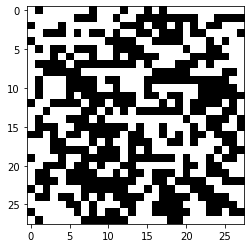

In [20]:
# feed the noises to the generator and predict them
generated_images = generator.predict(noise)
#we are going to see the first image i.e at index 0
x =generated_images[3].reshape(28,28)
# Let us plot the image
plt.imshow(x, cmap ="Greys")

In [13]:
#ONE ETERNITY LATER
#saving the model for future use
import sys
from google.colab import drive

In [14]:
drive.mount("/content/gdrive")

sys.path.insert(0,'/content/gdrive/My Drive/Models')
sys.path

Mounted at /content/gdrive


['/content/gdrive/My Drive/Models',
 '',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython']

In [15]:
path = '/content/gdrive/My Drive/Models/Version2'
generator.save(path)

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Models/Version2/assets


In [16]:
generator.save_weights("fashionGANmodel2.h5",path)

In [18]:
noise= np.random.normal(0,1, [batch_size, 28,28,1])